# nvImageCodecs with cuPy

In [16]:
import os
import cv2
import cupy as cp
from matplotlib import pyplot as plt
os.chdir("c:\\Users\\smatysik\\projects\\nvimagecodec\\build\\example\\example_decode\\RelWithDebInfo")
# os.chdir("/mnt/c/Users/smatysik/projects/nvImageCodecsWSL2/build/example/example_decode")
import nvimgcodecs

Load 4k, jpeg2000 image with nvImageCodecs

In [17]:
nv_img4k = nvimgcodecs.imread("4k_lossless.jp2")

Convert to cupy ndarray

In [18]:
%%time
cp_img4k = cp.asarray(nv_img4k)
# CHW(c-style) = Planar -> HWC (c-style) = Interleave
print(cp_img4k.__cuda_array_interface__)

cp_img4k = cp.moveaxis(cp_img4k, (0, 1, 2), (2, 0, 1))
print(cp_img4k.__cuda_array_interface__)
# In Fortran the most rapidly changing index comes first
#cp_img4k = cp.asfortranarray(cp_img4k)
#print(cp_img4k.__cuda_array_interface__)
#cp_img4k = cp.ascontiguousarray(cp_img4k)
#print(cp_img4k.__cuda_array_interface__)


{'shape': (3, 2160, 3840), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (8847360, 4096, 1), 'data': (34716254208, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (4096, 1, 8847360), 'data': (34716254208, False)}
CPU times: total: 0 ns
Wall time: 39.3 ms


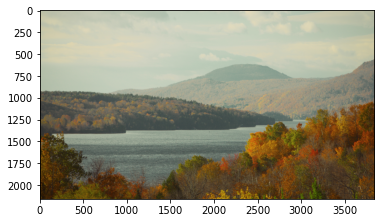

In [19]:
np_img4k = cp.asnumpy(cp_img4k)
plt.imshow(np_img4k)


Lets do some opration on image in GPU using cupyx.scipy

In [20]:
import cupyx.scipy.ndimage

In [21]:
cp_img_4k_rotated = cupyx.scipy.ndimage.rotate(cp_img4k, 90)
cp_img_4k_gaussian = cupyx.scipy.ndimage.gaussian_filter(cp_img4k, sigma = 15)
cp_img_4k_laplace = cupyx.scipy.ndimage.laplace(cp_img4k)

print(cp_img_4k_rotated.__cuda_array_interface__)

{'shape': (3840, 2160, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (34661164032, False)}


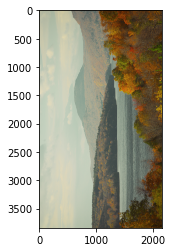

In [22]:
np_img_4k = cp.asnumpy(cp_img_4k_rotated)
plt.imshow(np_img_4k)

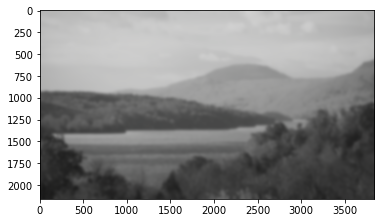

In [23]:
np_img_4k = cp.asnumpy(cp_img_4k_gaussian)
plt.imshow(np_img_4k)


Save as JPEG2000

nvJpeg2000 now supports only Planar RGB and cupy ndarray is in interleaved RGB format so we need to convert it before providing buffer to nvJpeg2000. In future nvJpeg2000 should probably support I_RGB.

In [24]:
# HWC (C-style) -> CHW (C-style)
print(cp_img_4k_rotated.__cuda_array_interface__)

cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated, (0, 1, 2), (1, 0, 2))
print(cp_img_4k_rotated_planar.__cuda_array_interface__)

cp_img_4k_rotated_planar = cp.asfortranarray(cp_img_4k_rotated_planar)
print(cp_img_4k_rotated_planar.__cuda_array_interface__)


cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated_planar, (0, 1, 2), (2, 1, 0))
print(cp_img_4k_rotated_planar.__cuda_array_interface__)


{'shape': (3840, 2160, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (34661164032, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (3, 6480, 1), 'data': (34661164032, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (1, 2160, 8294400), 'data': (34460401664, False)}
{'shape': (3, 3840, 2160), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (34460401664, False)}


In [25]:
%%time
nv_rotated_img = nvimgcodecs.asimage(cp_img_4k_rotated_planar)


CPU times: total: 0 ns
Wall time: 4.01 ms


In [26]:
%%time
nvimgcodecs.imwrite("rotated.j2k", nv_rotated_img)


CPU times: total: 500 ms
Wall time: 578 ms


Load with OpenCv to verify

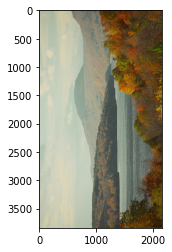

In [27]:
image = cv2.imread("rotated.j2k")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Save cupy image to jpg with nvImageCodecs

In [28]:
%%time
nvimgcodecs.imwrite("rotated.jpg", nv_rotated_img)


CPU times: total: 62.5 ms
Wall time: 95.8 ms


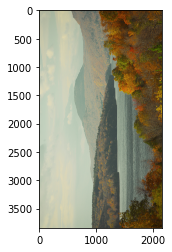

In [29]:
image = cv2.imread("rotated.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)